# Project Abstract

**Project Name:** Sentiment Analysis of Tweets

**Author:** Christopher Goh Zhen Fung
- **Email:** chrisgzf@gmail.com
- **LinkedIn:** https://www.linkedin.com/in/chrisgzf/
- **GitHub:** https://github.com/chrisgzf

This project is about sentiment analysis of online tweets. I would like to train a neural network to be able to recognise if tweets (or text in general) sound happy or sad.

**Why did I decide to work on this project:**
In recent years, there has been an unsettling trend of deteriorating mental health. If you browse social networks like Twitter, Reddit, Tumblr, you will realise that many depressed individuals have been going online to talk about their depression. In these cases, it is very common for other netizens to show concern to these individuals, often suggesting means to get help. With this tool, perhaps social workers can identify these at-risk individuals sooner and provide these individuals with care and companionship before they go over the edge.

**Parts to this Project**
1. Trying out sentiment analysis on an already available airline twitter sentiment dataset
2. Mining & data wrangling of tweets with Twitter Search API
3. Sentiment analysis on these "mood tweets"

**Credits:** I would like to thank Sam & Martin from Red Dragon AI for giving a very comprehensive and well-run deep learning jump start workshop, where I learnt the skills required to work on this project.

Please do feel free to point out any mistakes or provide me with any suggestions!

# Testing for CUDA-enabled TF with GPU Support

**What this means:**
Deep Learning requires a lot of matrix calculations and your CPU is not really meant for that sort of task. However, graphics cards (the hardware that your computer uses to make games run well) are able to perform these sort of tasks very well, so we need to check if the Jupyter Notebook has access to your (Nvidia) GPU, in order to train the model much more efficiently.

In [1]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
print(tf.test.is_built_with_cuda())
print(tf.keras.__version__)
print(tf.__version__)

True
2.2.4-tf
1.13.1


# 1. Trying out the CrowdFlower Airline Twitter Sentiment Dataset

Dataset obtained from: https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv

I found this dataset on Kaggle and it is pretty well organised. So I thought I would try out my sentiment analysis task on this dataset first, for two reasons:
1. As a proof of concept
2. When I generate my own "mood tweets" dataset, I can reference something that works

### Reading the CSV dataset with pandas

In [3]:
import pandas as pd

df = pd.read_csv("datasets/airline-twitter-sentiment.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


## Dropping Irrelevant Information
I'm only concerned about the sentiment & text. So I will drop the rest of the information

In [5]:
df = df[["airline_sentiment", "text"]]

Now let's analyse how the dataset is lain out and roughly how the data looks like

In [6]:
pd.set_option('display.max_colwidth', -1) # option to be set so that the tweet's texts won't be truncated
df.sort_values("airline_sentiment", inplace=True)
display(df.head())
display(df.tail())

,airline_sentiment,text
7319,negative,@JetBlue how do we watch the oscars though right now?! No abc on flight :( #missingtheoscars
11625,negative,@USAirways I've been sitting in the Charlotte airport for 4 hours. Waited for crew and now maintenance. #NeverAgain
6512,negative,@SouthwestAir I do need help Cancelled Flighting my flight back. Your calls times are ridiculous.
11624,negative,"@USAirways No, they won't because after 5 hours of holding I had to give up because I couldn't borrow the phone any longer. 5 hours..."
6514,negative,"@SouthwestAir your customer service is terrible, you're terrible, thought you should know."


,airline_sentiment,text
4822,positive,"@SouthwestAir kudos to the crew of flight 1050 to GRR for making a very special memory for a sweet young passenger, and her Momma. Well done"
7735,positive,@JetBlue your employee Charles cave at the gate at MSY went above and beyond to help try to help me find my glasses. Thought u should know
4818,positive,@SouthwestAir Thanks for helping my mom after @allegiantair wouldn't let her get on her plane in Orlando! You're the best! #customerservice
10895,positive,@USAirways made it!!! Send Bloody Mary's to row 27!!!
4078,positive,@united thanks for all the help! Totally appreciate it and you made it super easy too


We will now change the sentiment into a numerical representation to make it easier for deep learning.

In [7]:
df.loc[(df["airline_sentiment"] == "negative"), "airline_sentiment"] = 0 # replacing all "negative" with 0
df.loc[(df["airline_sentiment"] == "neutral"), "airline_sentiment"] = 1 # "neutral" with 1
df.loc[(df["airline_sentiment"] == "positive"), "airline_sentiment"] = 2 # "positive" with 2

display(df.head())
display(df.tail())
display(df.describe())

,airline_sentiment,text
7319,0,@JetBlue how do we watch the oscars though right now?! No abc on flight :( #missingtheoscars
11625,0,@USAirways I've been sitting in the Charlotte airport for 4 hours. Waited for crew and now maintenance. #NeverAgain
6512,0,@SouthwestAir I do need help Cancelled Flighting my flight back. Your calls times are ridiculous.
11624,0,"@USAirways No, they won't because after 5 hours of holding I had to give up because I couldn't borrow the phone any longer. 5 hours..."
6514,0,"@SouthwestAir your customer service is terrible, you're terrible, thought you should know."


,airline_sentiment,text
4822,2,"@SouthwestAir kudos to the crew of flight 1050 to GRR for making a very special memory for a sweet young passenger, and her Momma. Well done"
7735,2,@JetBlue your employee Charles cave at the gate at MSY went above and beyond to help try to help me find my glasses. Thought u should know
4818,2,@SouthwestAir Thanks for helping my mom after @allegiantair wouldn't let her get on her plane in Orlando! You're the best! #customerservice
10895,2,@USAirways made it!!! Send Bloody Mary's to row 27!!!
4078,2,@united thanks for all the help! Totally appreciate it and you made it super easy too


,airline_sentiment,text
count,14640,14640
unique,3,14427
top,0,@united thanks
freq,9178,6


## Loading Glove word embeddings.

Right now, we have our tweets in text form. In order for our neural network to take them in as inputs, they have to be numerical. Therefore, we will be performing 2 tasks:
1. Tokenising the text
2. Adding a second layer in the neural network to map the text to their respective word embeddings

Word embeddings are vector representations of distinct words in a vector space of many dimensions (in this case we are using 100 dimensions). This gives every word a distinct vector, and we can perform some very interesting vector operations on them.

A lot of the code here is referenced from: https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

Note: Please run the 2 cells below in a Linux environment / Google Colab so that the commands work properly. Windows might not have the proper binaries to perform these commands.

In [ ]:
!wget -qq http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove.6B.zip

The Glove word embeddings should be downloaded and unzipped. Check the output of the cell below to see if they are reflected correctly.

In [8]:
!ls

 datasets	     glove.6B.300d.txt	 LICENSE
 glove.6B.100d.txt   glove.6B.50d.txt	 README.md
 glove.6B.200d.txt   glove.6B.zip	'Sentiment Analysis of Tweets.ipynb'


Create a new dictionary to map the words in the embeddings to their 100-dimension embedding vector

In [11]:
import os
import numpy as np
# NumPy is a very widely-used library in Python for mathematical operations.
# It supports many complex mathematical functions and can work on large arrays and matrices.

embeddings_index = {}
with open(os.path.join('glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))

Found 400000 word vectors.


In [12]:
# to see what word embeddings look like
embeddings_index["chris"]

array([-0.37058 , -0.67807 ,  0.68365 , -1.8257  ,  0.033376, -0.19271 ,
        0.23817 ,  0.20734 , -0.59292 , -0.68866 ,  0.056996, -0.45526 ,
        0.050337,  0.38388 ,  0.5716  , -0.58939 , -0.065345, -0.15682 ,
       -0.71076 ,  0.80948 ,  0.28472 ,  0.33693 ,  0.16452 , -0.10708 ,
        0.93074 ,  0.63066 ,  0.31136 , -0.47565 ,  0.26755 ,  0.43212 ,
       -0.54809 ,  0.45665 , -0.13095 ,  0.41672 ,  0.07025 , -1.0302  ,
       -0.21576 ,  0.34737 , -0.52304 ,  0.43099 , -0.39802 , -0.25244 ,
        0.39093 ,  0.58856 , -1.1839  ,  0.31923 , -1.0152  , -0.32431 ,
       -0.099747, -0.12774 ,  0.20104 ,  0.16763 , -0.59854 , -0.25134 ,
        0.49871 , -2.4691  , -0.88555 , -0.14335 , -0.037509,  0.87851 ,
        0.086941, -0.097006, -0.59662 ,  0.63888 ,  0.72839 , -0.87794 ,
        0.71174 ,  1.1118  , -0.26572 ,  0.3617  , -0.43472 ,  0.17808 ,
       -0.57865 , -0.20282 ,  0.3917  , -0.37085 , -0.37463 ,  0.024523,
        0.017991, -0.43885 ,  0.093244, -0.019675, 

This array of numbers make up the representation of the word "chris" in 100d-space. This is beneficial as it gives every trained word a distinct vector representation, and we can calculate the cosine similarity between 2 different words to determine how similar / different the words are, in terms of contextual information.

## Processing them for TensorFlow

TensorFlow (& Keras) is the library/framework which we will use to train our neural network.

We will process our dataframe above into TF-ready numpy arrays.

In [13]:
import sys

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant

In [14]:
# Setting some parameters

MAX_SEQUENCE_LENGTH = 40 # determines how many words of every tweet will be processed
# if the tweet length is smaller than this, the tweet will be padded until it has a length equivalent to this

MAX_NUM_WORDS = 20000 # how many unique words in the training text to be tokenised
EMBEDDING_DIM = 100 # number of dimensions in the word embeddings
TRAINING_SPLIT = 0.8 # proportion of data to be used to training

In [15]:
# Converting the dataframe into lists

texts = df["text"].tolist()
labels = df["airline_sentiment"].tolist()

## Tokenising the Tweets into a 2D integer tensor

Tokenising tweets will break up the text into individual words, and replace them with a numeric representation.

e.g. 
- "I am a human" > "i", "am", "a", "human" > 1, 2, 3, 4
- "I am a robot" > "i", "am", "a", "robot" > 1, 2, 3, 5

In [16]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print("{} distinct words in original text".format(len(word_index)))

15768 distinct words in original text


All our tensors have to be of the same length, so we need to set a maximum length, and if a certain tweet has fewer than the maximum length of words, it will be padded until it is the same size.

36

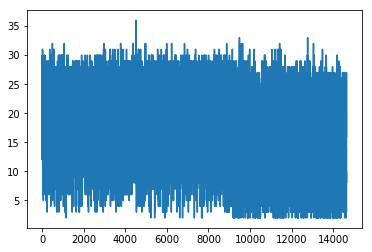

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
seq_lengths = [len(x) for x in sequences]
plt.plot(seq_lengths)
max(seq_lengths)

As seen from the graph, the tweets vary quite a lot in length, and maxes out at 36. We will now pad all of them to 36.

In [18]:
MAX_SEQUENCE_LENGTH = max(seq_lengths)

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Take note that if you set the maximum sequence length to be 36 during training, after your model is trained, it can only predict text up to 36 words as well. You may wish to increase the number above **before training** to give yourself more flexibility.

## Creating One Hot Encoding Labels

In [19]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (14640, 36)
Shape of label tensor: (14640, 3)


## Splitting the data into a train test split

What this means is that we will allocate 80% of our cleaned up dataset for training the neural network. After every epoch (cycle) of training, the model will be "examined" against the other 20%, named the validation set, to see how well our model generalises (whether our model is 'memorising' its training set, which is undesirable).

In [20]:
# we shuffle our sorted data, to make it random first
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# before we begin to split them
num_training_samples = int(TRAINING_SPLIT * data.shape[0])

In [21]:
x_train = data[:num_training_samples]
y_train = labels[:num_training_samples]
x_val = data[num_training_samples:]
y_val = labels[num_training_samples:]

## Preparing Embedding Matrix

In [22]:
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## Defining and creating our model

In [23]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(128)(embedded_sequences)

preds = Dense(labels.shape[1], activation='softmax')(x)
model = Model(sequence_input, preds)


Instructions for updating:
Colocations handled automatically by placer.


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 36)                0         
_________________________________________________________________
embedding (Embedding)        (None, 36, 100)           1576900   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 1,694,535
Trainable params: 117,635
Non-trainable params: 1,576,900
_________________________________________________________________


In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

## Training the model

In [26]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

Train on 11712 samples, validate on 2928 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
11712/11712 [==============================] - 7s 576us/sample - loss: 0.7311 - acc: 0.6997 - val_loss: 0.7483 - val_acc: 0.7240
Epoch 2/10
11712/11712 [==============================] - 6s 503us/sample - loss: 0.6280 - acc: 0.7450 - val_loss: 0.5924 - val_acc: 0.7527
Epoch 3/10
11712/11712 [==============================] - 6s 504us/sample - loss: 0.5875 - acc: 0.7610 - val_loss: 0.5686 - val_acc: 0.7688
Epoch 4/10
11712/11712 [==============================] - 6s 492us/sample - loss: 0.5578 - acc: 0.7719 - val_loss: 0.5784 - val_acc: 0.7657
Epoch 5/10
11712/11712 [==============================] - 6s 501us/sample - loss: 0.5368 - acc: 0.7812 - val_loss: 0.6173 - val_acc: 0.7555
Epoch 6/10
11712/11712 [==============================] - 6s 499us/sample - loss: 0.5126 - acc: 0.7935 - val_loss: 0.5788 - val_acc: 0.7630
Epoch 7/10
11712/11712 [==============================] - 6s 50

## Making predictions with the model

Our model is now trained! We have come to the exciting part where we try to make predictions with our model and see how well it predicts whether a tweet to an airline is negative or neutral or positive. Give it a try with your own input!

In [27]:
def predict_tweet(text_to_predict):
    test_sequence = tokenizer.texts_to_sequences([text_to_predict])
    test_data = pad_sequences(test_sequence, maxlen=MAX_SEQUENCE_LENGTH)
    prediction = np.argmax(model.predict(test_data))
    results = {
    0: "The tweet is negative about the airline.",
    1: "The tweet is neutral about the airline.",
    2: "The tweet is positive about the airline. Well done!"
    }
    print(results[prediction])

In [28]:
predict_tweet("Good job! Everyone that served me was friendly.")

The tweet is positive about the airline. Well done!


In [29]:
predict_tweet("Food was horrible")

The tweet is negative about the airline.


In [30]:
predict_tweet("Food was horrible but the air-stewardesses were fantastic to me")

The tweet is positive about the airline. Well done!


In [36]:
predict_tweet("Any chance there will be a discount on the tickets this week?")

The tweet is neutral about the airline.


In [38]:
predict_tweet("Checking in was smooth and efficient.")

The tweet is positive about the airline. Well done!


In [39]:
predict_tweet("In-flight entertainment was faulty")

The tweet is negative about the airline.


We are done! Now please open `2. Creating Mood Tweets Dataset.ipynb` for the next notebook on obtaining our mood tweets dataset.